In [2]:
!pip install datasets
!pip install --upgrade ragas
!pip install ragas llama_index

In [3]:
import re
import pandas as pd
import numpy as np
import os
from datasets import Dataset
import logging
import boto3
import json

In [4]:
logging.basicConfig(level=logging.INFO)


In [5]:
def get_secret(secret_name):
    region_name = "us-east-1"
    client = boto3.client("secretsmanager", region_name=region_name)

    try:
        response = client.get_secret_value(SecretId=secret_name)
        return json.loads(response["SecretString"])
    except Exception as e:
        print(f"Error retrieving secret {secret_name}: {e}")
        return None

In [6]:
secret = get_secret("arn:aws:secretsmanager:us-east-1:686255941112:secret:HuggingfaceQdrantOpenAPI-UKUXlz")
if not secret:
    raise ValueError("Failed to retrieve secrets from AWS Secrets Manager")

openai_api_key = secret.get("OPENAI_API_KEY", "Key not found")
print("openai_api_key:", openai_api_key)
os.environ["OPENAI_API_KEY"] = openai_api_key

openai_api_key: sk-proj-GUQJOwBRYb5qzbmxCYhPT3BlbkFJQgHvVt5rhO8vaDmfKZbR


### 1. Testing RAGAS on sample datasets

In [18]:
from datasets import Dataset
import os
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness, answer_similarity, answer_relevancy, context_recall, context_precision


data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'contexts' : [['The First AFL–NFL World Championship Game was an American football game played on January 15, 1967, at the Los Angeles Memorial Coliseum in Los Angeles,'],
    ['The Green Bay Packers...Green Bay, Wisconsin.','The Packers compete...Football Conference']],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}

dataset = Dataset.from_dict(data_samples)

score = evaluate(dataset,metrics=[faithfulness,answer_correctness, context_recall, context_precision, answer_similarity])
score.to_pandas()

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request

,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,context_recall,context_precision,semantic_similarity
0,When was the first super bowl?,[The First AFL–NFL World Championship Game was...,"The first superbowl was held on Jan 15, 1967","The first superbowl was held on January 15, 1967",1.0,0.999097,1.0,1.0,0.996387
1,Who won the most super bowls?,"[The Green Bay Packers...Green Bay, Wisconsin....",The most super bowls have been won by The New ...,The New England Patriots have won the Super Bo...,0.0,0.731072,0.0,0.0,0.924290


In [7]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /root/QA_system/inference/cohere_eval2


### 2.Cohere model results with section header (Pdf plumber )

In [9]:
import os
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness, answer_correctness, answer_similarity, 
    context_recall, context_precision, answer_relevancy
)

# Directory containing company folders
parent_directory = os.getcwd()
output_file = "./all_companies_results.csv"  # Final consolidated file

# Metrics to evaluate
metrics = [
    faithfulness, answer_correctness, context_recall, 
    context_precision, answer_similarity, answer_relevancy
]

# Initialize a DataFrame to store all results
compiled_results = pd.DataFrame()

# Initialize counters
total_questions = 0
total_evaluated_questions = 0

# List of companies to process
companies = ["bilt", "bitpay", "circle", "gdpr", "gemini", "klarna", "moonpay", "plaid", "remitly", "revolut", "stripe"]  # Add more if needed

# Loop through each company
for company in companies:
    company_path = os.path.join(parent_directory, company)
    print(f"Processing company: {company}")
    
    if os.path.isdir(company_path):
        csv_file = os.path.join(company_path, f"{company}.csv")
        
        # Check if the company's CSV file exists
        if os.path.exists(csv_file):
            # Load the company's CSV file
            df = pd.read_csv(csv_file)
            
            # Count total questions in the company's file
            num_questions = len(df)
            total_questions += num_questions
            
            # Extract relevant columns (adjust column names as per your dataset)
            df = df[['question', 'contexts', 'answer', 'ground_truth']]
            
            # Ensure `retrieved_contexts` is in list format
            df['retrieved_contexts'] = df['contexts'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [x]
            )
            
            # Prepare dataset for evaluation
            dataset = Dataset.from_pandas(df)
            
            # Evaluate metrics
            score = evaluate(dataset, metrics=metrics)
            score_df = score.to_pandas()

            # Count successfully evaluated questions
            num_evaluated_questions = len(score_df)
            total_evaluated_questions += num_evaluated_questions

            # Merge with original data
            merged_df = pd.concat([df, score_df], axis=1)
            merged_df['company'] = company  # Add company name for identification
            
            # Append to compiled results
            compiled_results = pd.concat([compiled_results, merged_df], ignore_index=True)
            
            print(f"Processed {num_questions} questions for {company}. Evaluated: {num_evaluated_questions}")
        else:
            print(f"No CSV file found for {company}")
    else:
        print(f"No directory found for {company}")

# Save the compiled results to a single CSV file
compiled_results.to_csv(output_file, index=False)
print(f"All results compiled and saved to: {output_file}")

# Print summary
print(f"Total questions across all companies: {total_questions}")
print(f"Total questions successfully evaluated: {total_evaluated_questions}")


Processing company: bilt


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 5 questions for bilt. Evaluated: 5
Processing company: bitpay


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 6 questions for bitpay. Evaluated: 6
Processing company: circle


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 5 questions for circle. Evaluated: 5
Processing company: gdpr


Evaluating:   0%|          | 0/234 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 39 questions for gdpr. Evaluated: 39
Processing company: gemini


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 6 questions for gemini. Evaluated: 6
Processing company: klarna


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 5 questions for klarna. Evaluated: 5
Processing company: moonpay


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 5 questions for moonpay. Evaluated: 5
Processing company: plaid


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 4 questions for plaid. Evaluated: 4
Processing company: remitly


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 5 questions for remitly. Evaluated: 5
Processing company: revolut


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 6 questions for revolut. Evaluated: 6
Processing company: stripe


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Processed 6 questions for stripe. Evaluated: 6
All results compiled and saved to: ./all_companies_results.csv
Total questions across all companies: 92
Total questions successfully evaluated: 92


In [28]:

weights = {
    'answer_relevancy': 0.45,      
    'faithfulness': 0.30,          
    'answer_correctness': 0.15,   
    'context_precision': 0.04,     
    'context_recall': 0.04,        
    'semantic_similarity': 0.02     
}

def calculate_weighted_avg(row, weights):
    weighted_sum = sum(row[metric] * weight for metric, weight in weights.items())
    return weighted_sum

ragas_df = pd.read_csv("all_companies_results.csv")

# Calculate weighted average
ragas_df['weighted_average'] = ragas_df.apply(calculate_weighted_avg, axis=1, weights=weights)

# Compute overall weighted average
overall_score = ragas_df['weighted_average'].mean()
print(f"Overall Weighted Average Score: {overall_score}")


Overall Weighted Average Score: 0.6500319008694851


In [29]:
# Add hallucination rate calculation to the weights
weights = {
    'answer_relevancy': 0.45,      
    'faithfulness': 0.30,          
    'answer_correctness': 0.15,   
    'context_precision': 0.04,     
    'context_recall': 0.04,        
    'semantic_similarity': 0.02,
    'hallucination_rate': -0.10   # Negative weight as hallucination impacts negatively
}

def calculate_hallucination_rate(row):
    """
    Calculate hallucination rate based on faithfulness and retrieved contexts.
    If faithfulness is low or retrieved contexts are unrelated, it indicates hallucination.
    """
    return 1 - row['faithfulness']  # Hallucination is inversely proportional to faithfulness

def calculate_weighted_avg(row, weights):
    """
    Calculate the weighted average score including hallucination rate.
    """
    weighted_sum = sum(row[metric] * weight for metric, weight in weights.items())
    return weighted_sum

# Read the CSV file
ragas_df = pd.read_csv("all_companies_results.csv")

# Calculate hallucination rate
ragas_df['hallucination_rate'] = ragas_df.apply(calculate_hallucination_rate, axis=1)

# Calculate weighted average score including hallucination rate
ragas_df['weighted_average'] = ragas_df.apply(calculate_weighted_avg, axis=1, weights=weights)

# Compute overall weighted average score
overall_score = ragas_df['weighted_average'].mean()
print(f"Overall Weighted Average Score (including hallucination rate): {overall_score}")

# Optional: Save the updated DataFrame
ragas_df.to_csv("all_companies_results_with_hallucination.csv", index=False)


Overall Weighted Average Score (including hallucination rate): 0.6074322561731252


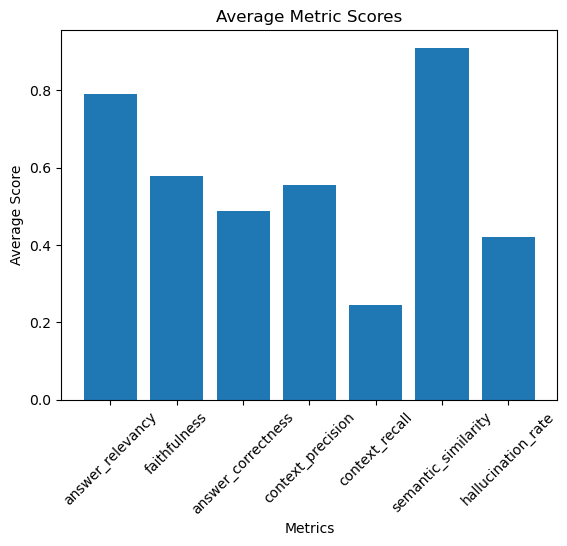

In [30]:
import matplotlib.pyplot as plt

metric_means = {metric: ragas_df[metric].mean() for metric in weights.keys()}

# Plot
plt.bar(metric_means.keys(), metric_means.values())
plt.title('Average Metric Scores')
plt.ylabel('Average Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.show()


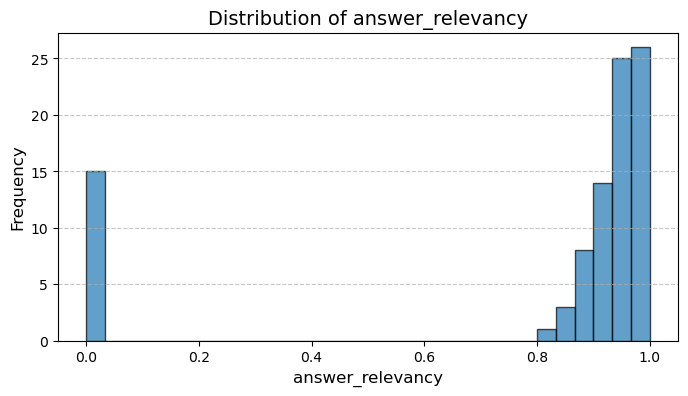

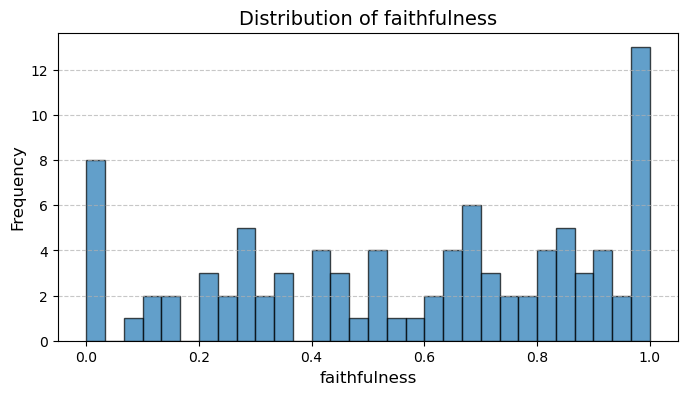

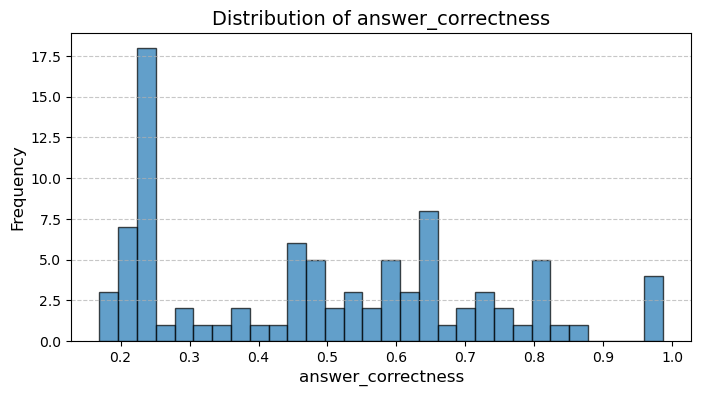

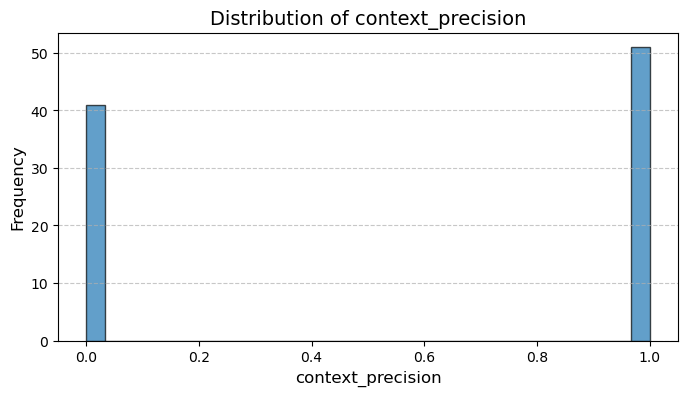

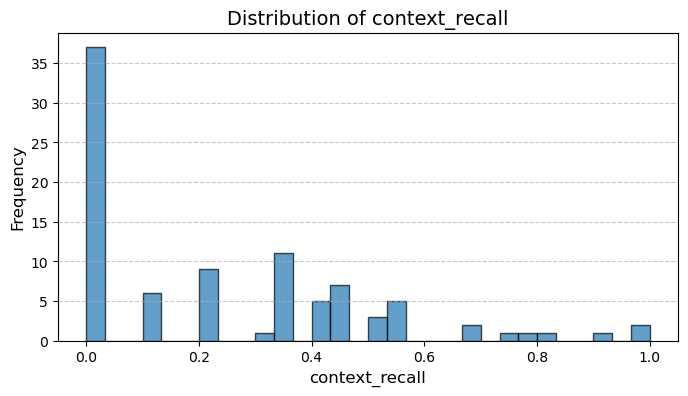

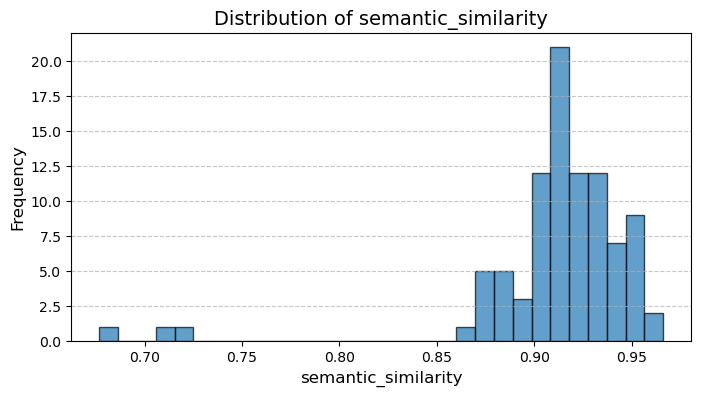

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the RAGAS evaluation results
ragas_df = pd.read_csv("all_companies_results.csv")

# List of metrics to visualize
metrics = [
    'answer_relevancy', 'faithfulness', 'answer_correctness', 
    'context_precision', 'context_recall', 'semantic_similarity'
]

# Plot the distribution of each metric
for metric in metrics:
    plt.figure(figsize=(8, 4))
    plt.hist(ragas_df[metric].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=14)
    plt.xlabel(metric, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
